In [20]:
import os
import torch
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [21]:
def compute_avg_cosine_similarity(epoch: int, layer_name: str, base_path: str):
    """
    Computes and prints the average cosine similarity between each task's gradient and the mean gradient.
    """
    
    layer_dir = os.path.join(
        base_path,
        f"grad_info_per_epoch",
        f"epoch{epoch}",
        layer_name
    )

    grad_list = []
    filenames = sorted([
        f for f in os.listdir(layer_dir) if f.endswith(".pt")
    ])

    for fname in filenames:
        grad = torch.load(os.path.join(layer_dir, fname))  # [D]
        grad_list.append(grad)

    grads = torch.stack(grad_list)  # [T, D]
    grad_mean = grads.mean(dim=0)   # [D]

    cos_sims = [F.cosine_similarity(g, grad_mean, dim=0).item() for g in grads]
    avg_sim = sum(cos_sims) / len(cos_sims)

    print(f"{layer_name} (epoch {epoch}): Avg cosine similarity = {avg_sim:.4f}")
    
    return avg_sim

In [22]:
def compute_avg_cosine_similarity_over_epochs(layer_name: str, base_path: str, epoch_list: list):
    """
    Computes and prints average cosine similarity for a specific layer across multiple epochs.
    """
    results = {}
    for epoch in epoch_list:
        try:
            avg_sim = compute_avg_cosine_similarity(epoch, layer_name, base_path)
            results[epoch] = avg_sim
        except Exception as e:
            print(f"[Warning] Epoch {epoch} failed: {e}")
    return results

In [23]:
def plot_cosine_similarity_all_layers(base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    plt.figure(figsize=(10, 6))

    for layer_name in layer_names:
        results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=base_path,
            epoch_list=epoch_list
        )

        # 정렬된 epoch 기준으로 x, y 값 준비
        sorted_epochs = sorted(results.keys())
        values = [results[ep] for ep in sorted_epochs]

        # 그래프 그리기
        plt.plot(sorted_epochs, values, label=layer_name)

    plt.xlabel("Epoch")
    plt.ylabel("Average Cosine Similarity")
    plt.title("Epoch-wise Cosine Similarity per Layer")
    plt.legend()
    plt.grid(True)
    
    # x축을 정수 눈금으로 강제 설정
    plt.xticks(sorted(epoch_list))  
    
    plt.tight_layout()
    plt.show()

In [24]:
def plot_compare_methods_all_layers(maml_base_path: str, our_base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    plt.figure(figsize=(10, 6))

    for layer_name in layer_names:
        # MAML (점선)
        maml_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            maml_values,
            label=f"MAML - {layer_name}",
            linestyle='dashed'
        )

        # OUR METHOD (실선)
        our_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            our_values,
            label=f"OURS - {layer_name}",
            linestyle='solid'
        )

    plt.xlabel("Epoch")
    plt.ylabel("Average Cosine Similarity")
    plt.title("Comparison of Cosine Similarity: MAML vs OURS")
    plt.legend(loc='best', fontsize=9)
    plt.grid(True)
    plt.xticks(sorted(epoch_list))
    plt.tight_layout()
    plt.show()

In [57]:
def plot_cosine_similarity_layerwise_subplots(maml_base_path: str, our_base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    num_layers = len(layer_names)
    nrows = (num_layers + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    axes = axes.flatten()

    for idx, layer_name in enumerate(layer_names):
        ax = axes[idx]

        # MAML
        maml_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        ax.plot(
            sorted_epochs,
            maml_values,
            label="MAML",
            linestyle='dashed'
        )

        # OURS
        our_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        ax.plot(
            sorted_epochs,
            our_values,
            label="OURS",
            linestyle='solid'
        )

        ax.set_title(layer_name, fontsize=10)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Avg Cosine Similarity")
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xticks(sorted(epoch_list))

    # 여분 subplot 제거
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [58]:
def plot_cosine_similarity_layerwise_individual(
    maml_base_path: str,
    our_base_path: str,
    epoch_list: list,
    save_dir: str = "gradient/cosine_similarity"
):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]
    
    save_dir = os.path.normpath(save_dir)
    os.makedirs(save_dir, exist_ok=True)

    for layer_name in layer_names:
        plt.figure(figsize=(8, 5))

        # MAML
        maml_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            maml_values,
            label="MAML",
            linestyle='dashed'
        )

        # OURS
        our_results = compute_avg_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            our_values,
            label="OURS",
            linestyle='solid'
        )

        # 그래프 설정
        plt.title(f"Avg Cosine Similarity - {layer_name}", fontsize=12)
        plt.xlabel("Epoch")
        plt.ylabel("Avg Cosine Similarity")
        plt.grid(True)
        plt.legend()
        plt.xticks(sorted(epoch_list))
        plt.tight_layout()
        
        # 저장
        filename = f"{layer_name}_cosine_similarity.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        plt.close()

        print(f"[Saved] {save_path}")


# 통합 비교하기

## 1) 전체 layer를 하나의 그래프로 표현하기

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0170
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0306
layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0231
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0443
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0454
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0289
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0284
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0319
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0075
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0393
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0388
layer_layer_dict_conv2_conv_weight (epoch 0): Avg cosine similarity = 0.0296

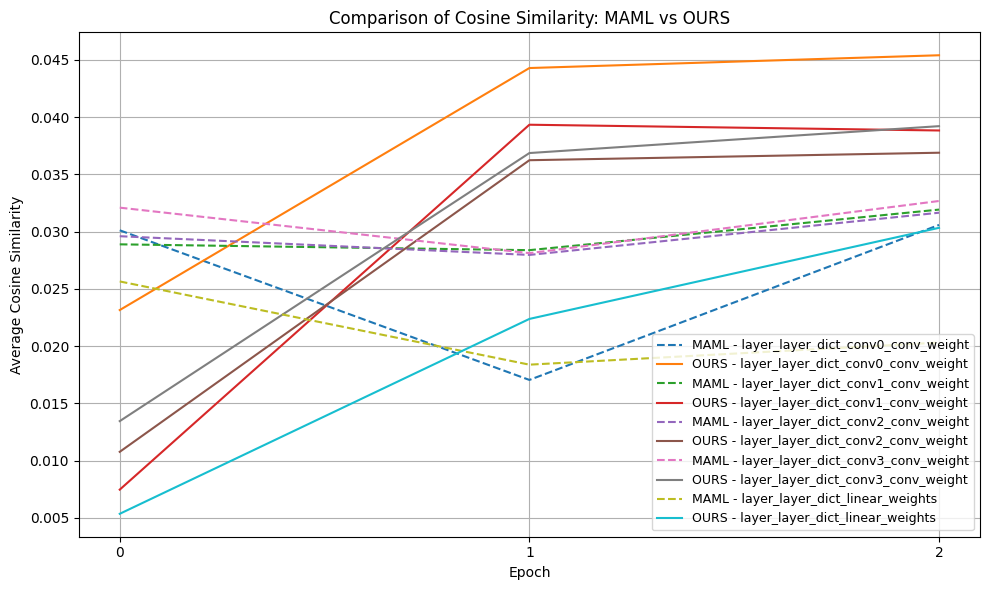

In [42]:
plot_compare_methods_all_layers(maml_base_path, our_base_path, epoch_list)

## 2) 전체 layer를 개별적인 그래프로 표현하기

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0170
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0306
layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0231
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0443
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0454
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0289
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0284
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0319
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0075
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0393
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0388
layer_layer_dict_conv2_conv_weight (epoch 0): Avg cosine similarity = 0.0296

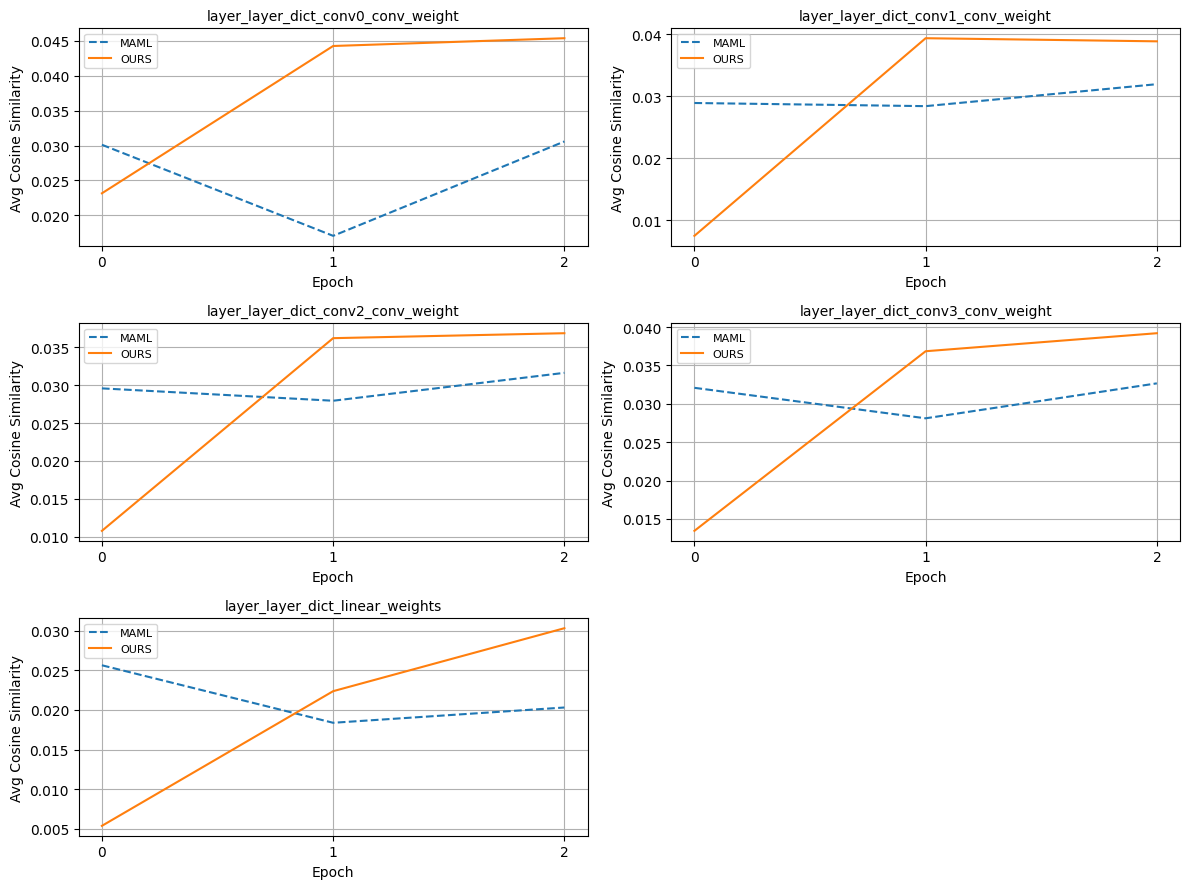

In [49]:
plot_cosine_similarity_layerwise_subplots(maml_base_path, our_base_path, epoch_list)

In [59]:
plot_cosine_similarity_layerwise_individual(maml_base_path, our_base_path, epoch_list)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0170
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0306
layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0231
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0443
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0454
[Saved] gradient\cosine_similarity\layer_layer_dict_conv0_conv_weight_cosine_similarity.png
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0289
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0284
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0319
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0075
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0393
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine simi

# MAML

## 특정 epoch에서 cosine 유사도 구하기

In [25]:
maml_base_path = "../MAML_5way_5shot_filter64_miniImagenet"

In [26]:
avg_sim = compute_avg_cosine_similarity(
    epoch=0,
    layer_name="layer_layer_dict_conv0_conv_weight",
    base_path=maml_base_path
)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301


## 전체 epoch에서 cosine 유사도 구하기

In [27]:
layer_name = "layer_layer_dict_conv0_conv_weight"
epochs = list(range(0, 4))  # 예: 0~9 epoch

results = compute_avg_cosine_similarity_over_epochs(layer_name, maml_base_path, epochs)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0170
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0306
layer_layer_dict_conv0_conv_weight (epoch 3): Avg cosine similarity = 0.0337


In [28]:
layer_name = "layer_layer_dict_conv1_conv_weight"
epochs = list(range(0, 4))  # 예: 0~9 epoch

results = compute_avg_cosine_similarity_over_epochs(layer_name, maml_base_path, epochs)

layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0289
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0284
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0319
layer_layer_dict_conv1_conv_weight (epoch 3): Avg cosine similarity = 0.0331


In [29]:
layer_name = "layer_layer_dict_conv2_conv_weight"
epochs = list(range(0, 4))  # 예: 0~9 epoch

results = compute_avg_cosine_similarity_over_epochs(layer_name, maml_base_path, epochs)

layer_layer_dict_conv2_conv_weight (epoch 0): Avg cosine similarity = 0.0296
layer_layer_dict_conv2_conv_weight (epoch 1): Avg cosine similarity = 0.0280
layer_layer_dict_conv2_conv_weight (epoch 2): Avg cosine similarity = 0.0316
layer_layer_dict_conv2_conv_weight (epoch 3): Avg cosine similarity = 0.0320


In [30]:
layer_name = "layer_layer_dict_conv3_conv_weight"
epochs = list(range(0, 4))  # 예: 0~9 epoch

results = compute_avg_cosine_similarity_over_epochs(layer_name, maml_base_path, epochs)

layer_layer_dict_conv3_conv_weight (epoch 0): Avg cosine similarity = 0.0321
layer_layer_dict_conv3_conv_weight (epoch 1): Avg cosine similarity = 0.0281
layer_layer_dict_conv3_conv_weight (epoch 2): Avg cosine similarity = 0.0327
layer_layer_dict_conv3_conv_weight (epoch 3): Avg cosine similarity = 0.0305


In [31]:
layer_name = "layer_layer_dict_linear_weights"
epochs = list(range(0, 4))  # 예: 0~9 epoch

results = compute_avg_cosine_similarity_over_epochs(layer_name, maml_base_path, epochs)

layer_layer_dict_linear_weights (epoch 0): Avg cosine similarity = 0.0256
layer_layer_dict_linear_weights (epoch 1): Avg cosine similarity = 0.0184
layer_layer_dict_linear_weights (epoch 2): Avg cosine similarity = 0.0203
layer_layer_dict_linear_weights (epoch 3): Avg cosine similarity = 0.0184


## 전체 layer의 cosine similarity를 시각화하는 코드

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0301
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0170
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0306
layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0289
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0284
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0319
layer_layer_dict_conv2_conv_weight (epoch 0): Avg cosine similarity = 0.0296
layer_layer_dict_conv2_conv_weight (epoch 1): Avg cosine similarity = 0.0280
layer_layer_dict_conv2_conv_weight (epoch 2): Avg cosine similarity = 0.0316
layer_layer_dict_conv3_conv_weight (epoch 0): Avg cosine similarity = 0.0321
layer_layer_dict_conv3_conv_weight (epoch 1): Avg cosine similarity = 0.0281
layer_layer_dict_conv3_conv_weight (epoch 2): Avg cosine similarity = 0.0327
layer_layer_dict_linear_weights (epoch 0): Avg cosine similarity = 0.0256
la

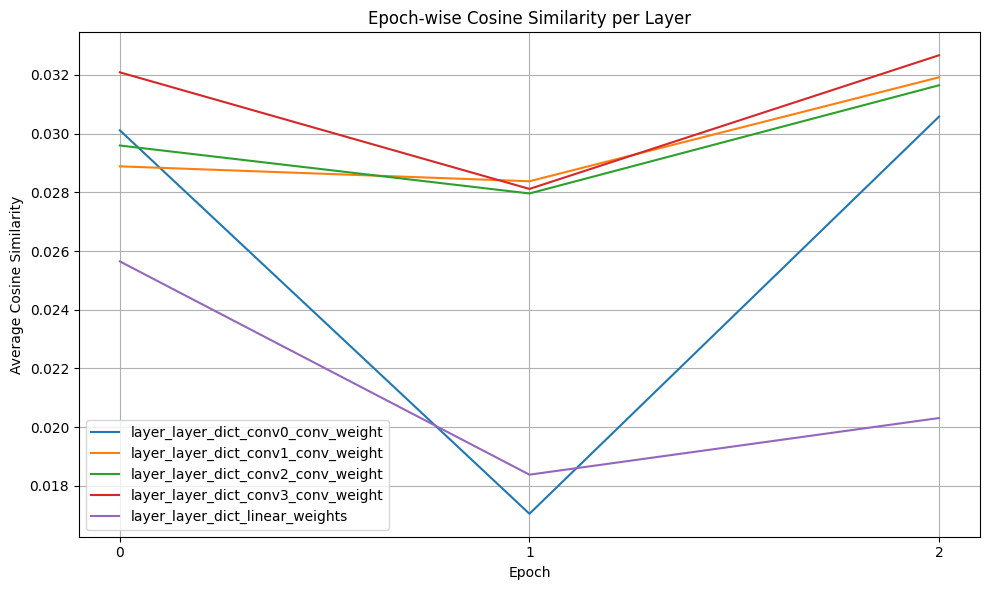

In [32]:
epoch_list = list(range(0, 3))  # 0부터 49까지
plot_cosine_similarity_all_layers(maml_base_path, epoch_list)

# Our

## 특정 epoch에서 cosine 유사도 구하기

In [33]:
our_base_path = "../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet"

In [35]:
avg_sim = compute_avg_cosine_similarity(
    epoch=0,
    layer_name="layer_layer_dict_conv0_conv_weight",
    base_path=our_base_path
)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0231


## 전체 epoch에서 cosine 유사도 구하기

In [36]:
layer_name = "layer_layer_dict_conv0_conv_weight"
results = compute_avg_cosine_similarity_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg cosine similarity = 0.0231
layer_layer_dict_conv0_conv_weight (epoch 1): Avg cosine similarity = 0.0443
layer_layer_dict_conv0_conv_weight (epoch 2): Avg cosine similarity = 0.0454
[Warning] Epoch 3 failed: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet\\grad_info_per_epoch\\epoch3\\layer_layer_dict_conv0_conv_weight'


In [37]:
layer_name = "layer_layer_dict_conv1_conv_weight"
results = compute_avg_cosine_similarity_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv1_conv_weight (epoch 0): Avg cosine similarity = 0.0075
layer_layer_dict_conv1_conv_weight (epoch 1): Avg cosine similarity = 0.0393
layer_layer_dict_conv1_conv_weight (epoch 2): Avg cosine similarity = 0.0388
[Warning] Epoch 3 failed: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet\\grad_info_per_epoch\\epoch3\\layer_layer_dict_conv1_conv_weight'


In [38]:
layer_name = "layer_layer_dict_conv2_conv_weight"
results = compute_avg_cosine_similarity_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv2_conv_weight (epoch 0): Avg cosine similarity = 0.0108
layer_layer_dict_conv2_conv_weight (epoch 1): Avg cosine similarity = 0.0362
layer_layer_dict_conv2_conv_weight (epoch 2): Avg cosine similarity = 0.0369
[Warning] Epoch 3 failed: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet\\grad_info_per_epoch\\epoch3\\layer_layer_dict_conv2_conv_weight'


In [39]:
layer_name = "layer_layer_dict_conv3_conv_weight"
results = compute_avg_cosine_similarity_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv3_conv_weight (epoch 0): Avg cosine similarity = 0.0134
layer_layer_dict_conv3_conv_weight (epoch 1): Avg cosine similarity = 0.0369
layer_layer_dict_conv3_conv_weight (epoch 2): Avg cosine similarity = 0.0392
[Warning] Epoch 3 failed: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet\\grad_info_per_epoch\\epoch3\\layer_layer_dict_conv3_conv_weight'


In [40]:
layer_name = "layer_layer_dict_linear_weights"
results = compute_avg_cosine_similarity_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_linear_weights (epoch 0): Avg cosine similarity = 0.0054
layer_layer_dict_linear_weights (epoch 1): Avg cosine similarity = 0.0224
layer_layer_dict_linear_weights (epoch 2): Avg cosine similarity = 0.0303
[Warning] Epoch 3 failed: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet\\grad_info_per_epoch\\epoch3\\layer_layer_dict_linear_weights'
